In [1]:
import pandas as pd
import pyarrow
import datetime as dt
import numpy as np

In [2]:
import data_preparing_tools

In [3]:
df_transactions = pd.read_parquet('transactions.parquet')

In [4]:
df_clients = pd.read_csv('clients.csv')

In [5]:
df_trans = df_transactions.sort_values(by=['client_id', 'chq_date'])

In [6]:
df_trans['client_id'] = df_trans['client_id'].astype(str) 

Мы хотим узнать, как долго клиент пользовался сервисом. Поэтому строим датасет $df2$. Также сколько покупок он совершил за всё это время $df3$. Потом соединяем их в единый  датасет и объедиям с $df clients$

In [7]:
df2 = df_trans.groupby(['client_id']).agg({'chq_date':['min','max']})

In [8]:
df2.columns = df2.columns.map(''.join)
df2['total_service_lenghth'] = df2.chq_datemax - df2.chq_datemin
df2['total_service_lenghth'] = pd.to_numeric(df2['total_service_lenghth'].dt.days, downcast='integer')
df2 = df2.rename(columns={"chq_datemax": "check_last_date", "chq_datemin": "check_first_date"})
df2.reset_index(drop=False, inplace=True)

In [9]:
df3 = df_trans.groupby(['client_id'])['chq_id'].nunique().to_frame()
df3.columns = df3.columns.map(''.join)
df3.reset_index(drop=False, inplace=True)

In [10]:
res = pd.merge(df2, df3, on= ['client_id'])
res = res.rename(columns={"chq_id":'total_amount_of_purchases'})

In [11]:
full_clients_df = pd.merge(df_clients, res , on=['client_id'])

Выбросим колонки $gender$ и $birthyear$ за ненадобностью.

In [12]:
full_clients_df = full_clients_df.drop(['gender', 'birthyear'], axis=1)

In [13]:
full_clients_df 

,client_id,city,check_first_date,check_last_date,total_service_lenghth,total_amount_of_purchases
0,1a47d62dddacc03fe90c15652f7ae1a4,Other,2016-10-08,2017-09-30,357,15
1,9cb909f701d25d548e953bff81192b56,Other,2016-10-28,2017-08-15,291,18
2,d5da0f5b841b4f83383202807995027a,Other,2016-10-16,2017-09-18,337,6
3,13ed7f16810b17b8cee6de834ac79a48,Moscow,2016-10-28,2017-08-31,307,5
4,215fe3ea7d5bf0415e5504e2a7f33551,Other,2016-10-07,2017-08-25,322,59
...,...,...,...,...,...,...
99990,9e7e66fc2c2dcfd8977bc0cffeff8eb5,Other,2016-10-11,2017-10-01,355,61
99991,e261c97d40ab839926c712b4aa6cefd8,St. Petersburg,2016-11-01,2017-07-20,261,14
99992,678ef46f41f8c89f7e8578c9e9592e3e,Other,2016-12-02,2017-02-12,72,7
99993,274facf0609ceba803f5853bd2222208,Other,2016-10-30,2017-02-12,105,5


In [14]:
full_clients_df['days_from_last_chq'] = df_trans.chq_date.max() - full_clients_df.check_last_date
full_clients_df['days_from_last_chq'] = pd.to_numeric(full_clients_df['days_from_last_chq'] .dt.days, downcast='integer')


In [15]:
full_clients_df['purchase_density'] = full_clients_df['total_amount_of_purchases'] / (full_clients_df['total_service_lenghth']+1)
full_clients_df


,client_id,city,check_first_date,check_last_date,total_service_lenghth,total_amount_of_purchases,days_from_last_chq,purchase_density
0,1a47d62dddacc03fe90c15652f7ae1a4,Other,2016-10-08,2017-09-30,357,15,4,0.041899
1,9cb909f701d25d548e953bff81192b56,Other,2016-10-28,2017-08-15,291,18,50,0.061644
2,d5da0f5b841b4f83383202807995027a,Other,2016-10-16,2017-09-18,337,6,16,0.017751
3,13ed7f16810b17b8cee6de834ac79a48,Moscow,2016-10-28,2017-08-31,307,5,34,0.016234
4,215fe3ea7d5bf0415e5504e2a7f33551,Other,2016-10-07,2017-08-25,322,59,40,0.182663
...,...,...,...,...,...,...,...,...
99990,9e7e66fc2c2dcfd8977bc0cffeff8eb5,Other,2016-10-11,2017-10-01,355,61,3,0.171348
99991,e261c97d40ab839926c712b4aa6cefd8,St. Petersburg,2016-11-01,2017-07-20,261,14,76,0.053435
99992,678ef46f41f8c89f7e8578c9e9592e3e,Other,2016-12-02,2017-02-12,72,7,234,0.095890
99993,274facf0609ceba803f5853bd2222208,Other,2016-10-30,2017-02-12,105,5,234,0.047170


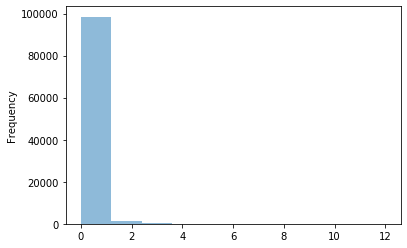

In [16]:
full_clients_df.purchase_density.plot.hist(alpha=0.5, bins=10)

Из гистограммы сверху мы видим, что в основном значения в $purchase density$ вариьируются от $0$ до $1$. Но есть значения и больше $1$. Таких клиентов не много и  их нельзя считать постоянными. За год они были в магазине всего пару раз и совершали большие покупки (длинные чеки). Скорее всего они забегали перед праздниками. Так как их мало, и частота их появления мала мы выкидываем их

In [17]:
full_result_clients_cut = full_clients_df[(full_clients_df.purchase_density <=1) ]

In [18]:
df_trans['week'] = df_trans.chq_date.dt.to_period(freq="W")

In [19]:
clients_cut = full_result_clients_cut.client_id.values
df_trans_cut = df_trans[df_trans.client_id.isin(clients_cut)]

Чтобы выявить отточных клиентов, мы будем сравнивать их финансовое поведение. Мы разобьем год на недели, и посчитаем сумму покупок в неделю. Дальше мы будем брать определенный период - 8 недель. Для восьми недель у нас будет восемь сумм.  Будем польщоваться статистическими тестами чтобы сравнить поведение клиентов. 

Сразу обговорю несколлько допущений. 


1) за рефересный период мы берем первые два месяца - это октябрь и ноябрь. Предполагается, что эти месяцы могут давать представление об усредненном поведении клиентов. В них нет крупных праздников, каникул итд. Те поведение клиента будет стандартным "работа - лента -дом"

2) статистические тесты сравнивают похожесть двух выборок, но не указывают на то, упала ли активность клиента по сравнению с тестовой выборкой или возросла. Для индикации этого процесса мы введем специальный коэффициент, который будет принимать значение -1 если активность падает, и +1 если возрастает. Pvalue будет умножаться на данный коэффициент.

3) Мы составим два датасета, чтобы проанализировать поведение клиента с разных точек зрения. Мы сравним их по отдельности и объединим.  В первом датасете мы будем сравнивать финансовое поведение клиента. Во-втором, просто заходил клиент в магазин или нет (количество заходов в неделю.

4) В первом случае мы просумммируем траты на каждой недее в году, разобьем их на выборке в два месяца и будет прогонять тест Крускала-Уолисса для получения pvalue.   По этому значению можно судить, походи выборки, или нет. Для подсчета коэффициента мы будем сравнивать медиану и среднее сумм покупок, если мы види что эти показатели не меняются сильно или растут, мы умножаем на +1. В случае, если же эти показатели падают по сравнению с реверенсом - умножаем на -1.

5) Во втором случае мы будем сравнивать численную активность клиента - количеество заходов на неделе. ТЕст остается тем же - Крускалл Уоллис. Для подсчета коэффициентов мы будем сравнивать, возрастает ли количество недель, что клиент не заходит в магазин или падает. Если падаеет - умножаем на +1,  если возрастает - -1.

6) Если выборка которая сравнивается с референсной полностью состоит из нулей (для обоих случаев) мы приравниваем результрующее pvalue к -1.

7) Тест Крускалла_Уоллиса был выбран мною по следующим соображениям: 1) он непарметрический и может применяться для выборок, чье распределение мы изначально не знаем 2) он работает с ранками, а не с самими значениями - следовательно, он устойчив к выбросам.

8) Модели нельзя давать данные за весь период, потому что модель сразу различит постоянного клиента, от того, который ушел. Я буду выделять предполагаемы период ухода - 2 месяца и брать четыре месяца до этого ухода. Для всех этих данных я посчитаю численные характеристики (о них ниже) еще раз отсею тех кто ушел от тех кто не ушел и раздам классы.

Здесь и далее пойдет полотно кода, который следовало бы обернуть в функции. Я сразу прошу прощения, что не сделала это


Здесь я буду готовить два датасета 'df_result_chqs.csv' и 'df_result_sums.csv'.   Для начала я посчитаю сумму покупок для 'df_result_sums.csv' и количество заходов для 'df_result_chqs.csv' по неделям. Потом прогоню стат тест Крускалла-Уолиса, домножая это на коэффициент. Тк у нас в случае пустых недель для обоих датасетов будет выдаваться -1 как pvalue* coeff я сравню медианы полученных 6  pvalue с единицей. Что значит  pvalue* coeff== -1? -значит в выборке, которую я сравниваю с референсной, из 2 месяцев, все недели  пустые - те клиент не заходил в магазин. Что значит медиана полученных значений равна -1 (или около того) ? значит было больше 3 выборок, в которых все недели пустые. Эти клиенты представляют собой выборку из очень разряженных по поведению покуппателей, часто встречается такая картина, что клиент был в магазине меньше 10 раз за год. Это не репрезентативный клиент и мы не можем анализировать его поведение. Мы выкидываем таких клиентов. Для оставшихся будем считать следующие характеристики:

В качестве фич я взяла численные характеристики, которые по моему мнению, отражют поведение клиента:

Период =4 месяца до предполагаемого ухода

1) total_num_chqs - количество покупок за наблюдаемый период

2) total_num_days - количество раз заходов в магазин (например чек если мы заходили два раза в 23/12/20 то мы считаем за один раз6 по количеству уникальных дат)

3) num_unique_goods - сколько всего было куплено уникальных продуктов за весь период

4) total_money_spent - сколько денег потрачено за весь период

5) total_is_promo_sum - сколько денег потрачено за весь период на акционные товары

6) trend_coef очень игрушечная фича, и если честно я в ней сомневаюсь. Она представляет собой разность суммы  \заходов в первый и последний месяц, деленное на среднее за весь период (в результирующем датасете я выкину эту х-ку, тк неразумно брать среднее от сумм и заходов в магазин.

7) sparsity - количество пустых недель (без транзакций) деленное на 16

При получении колонки  sparsity  мы еще раз проверим верно ли наше разделение - 
Если значение sparsity <0.2 значит поведение клиента плотное и мы не можем говорить о его уходе
если sparsity>0.8  то клиент вряд ли задержался

In [20]:
weeks, weeks_client_sum = data_preparing_tools.weeks_get_dummies(df_trans_cut, 'chq_date')

/Users/Anna.Rudenko/data_preparing_tools.py:74: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  week_clients_sums =  week_sums_dummies.groupby('client_id')['01',


In [21]:
weeks_client_sum

,client_id,01,02,03,04,05,06,07,08,09,...,44,45,46,47,48,49,50,51,52,53
0,0000d48a8891cd462fdf01ea861ec53e,0,0,0,0,12,0,15,0,20,...,0,45,0,0,14,0,0,0,0,0
1,00028a1dcb30863404a386961a69300e,12,0,24,0,11,0,0,0,0,...,8,21,0,14,2,8,15,0,0,0
2,0004274683494a9eca5e70ef97299d55,15,16,22,10,8,18,20,15,36,...,19,13,23,6,7,48,36,19,0,14
3,00072f81efcb3481861f7300c5e2a88a,0,0,0,11,0,0,1,3,0,...,0,0,0,0,0,4,0,0,0,0
4,00076596eb749cf10c2e984621dffe95,88,16,47,24,0,0,0,0,78,...,56,52,75,27,27,47,20,43,21,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98450,fffb2f36eb72ff56d2ef7a2685714f01,24,0,13,8,36,0,0,0,9,...,0,0,0,0,0,0,9,0,0,0
98451,fffb50df95231c0f090b5aa3f5332c7f,19,0,1,8,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98452,fffc3f2be1422d248dbeda4196ef0711,0,2,6,0,0,0,7,4,16,...,8,20,0,0,0,0,0,8,0,0
98453,fffc477269ae5f219e39aa51fa7abb81,0,0,0,25,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
weeks2, weeks_client_sum2 = data_preparing_tools.weeks_get_dummies(df_trans_cut, 'sales_sum')

/Users/Anna.Rudenko/data_preparing_tools.py:74: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  week_clients_sums =  week_sums_dummies.groupby('client_id')['01',


In [23]:
weeks_client_sum2

,client_id,01,02,03,04,05,06,07,08,09,...,44,45,46,47,48,49,50,51,52,53
0,0000d48a8891cd462fdf01ea861ec53e,0.0,0.0,0.0,0.0,1655.0,0.0,2475.0,0.0,4481.0,...,0.0,7596.0,0.0,0.0,2046.0,0.0,0.0,0.0,0.0,0.0
1,00028a1dcb30863404a386961a69300e,678.0,0.0,2450.0,0.0,1841.0,0.0,0.0,0.0,0.0,...,847.0,1569.0,0.0,1053.0,45.0,577.0,1205.0,0.0,0.0,0.0
2,0004274683494a9eca5e70ef97299d55,1175.0,1819.0,1085.0,527.0,538.0,1357.0,2239.0,792.0,3306.0,...,1137.0,667.0,1788.0,306.0,463.0,5067.0,3510.0,1151.0,0.0,5095.0
3,00072f81efcb3481861f7300c5e2a88a,0.0,0.0,0.0,571.0,0.0,0.0,299.0,192.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1812.0,0.0,0.0,0.0,0.0
4,00076596eb749cf10c2e984621dffe95,9225.0,1578.0,3624.0,1812.0,0.0,0.0,0.0,0.0,6252.0,...,5212.0,4193.0,7827.0,2915.0,1650.0,4044.0,2303.0,3659.0,2454.0,3351.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98450,fffb2f36eb72ff56d2ef7a2685714f01,2699.0,0.0,1719.0,640.0,4334.0,0.0,0.0,0.0,451.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2057.0,0.0,0.0,0.0
98451,fffb50df95231c0f090b5aa3f5332c7f,1416.0,0.0,39.0,463.0,182.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98452,fffc3f2be1422d248dbeda4196ef0711,0.0,116.0,773.0,0.0,0.0,0.0,543.0,1067.0,2939.0,...,1791.0,3682.0,0.0,0.0,0.0,0.0,0.0,964.0,0.0,0.0
98453,fffc477269ae5f219e39aa51fa7abb81,0.0,0.0,0.0,8009.0,0.0,8582.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
pvalues_clients_3_cut = data_preparing_tools.kruskal_sums(weeks2, weeks_client_sum2 )

/Users/Anna.Rudenko/data_preparing_tools.py:109: RuntimeWarning: divide by zero encountered in double_scalars
  if(com_data.mean() >=ref_mean_) | ( ref_mean_ / com_data.mean()<=5):
/Users/Anna.Rudenko/data_preparing_tools.py:109: RuntimeWarning: invalid value encountered in double_scalars
  if(com_data.mean() >=ref_mean_) | ( ref_mean_ / com_data.mean()<=5):
/Users/Anna.Rudenko/data_preparing_tools.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  if(com_data.mean() >=ref_mean_) | ( ref_mean_ / com_data.mean()<=5):


In [27]:
pvalues_clients_3_cut1 = data_preparing_tools.define_churn(pvalues_clients_3_cut)

In [28]:
pvalues_clients_3_cut1

,client_id,1,2,3,4,5,6,gone_5_6,gone_7_8,gone_9_10,gone_11_13,gone
0,0000d48a8891cd462fdf01ea861ec53e,0.164915,0.062357,0.056517,0.001216,0.105193,-1.000000,0,0,0,0,0
1,00028a1dcb30863404a386961a69300e,0.701671,0.487453,0.951886,0.197035,0.510671,0.802311,0,0,0,0,0
2,0004274683494a9eca5e70ef97299d55,0.833635,0.074203,0.045999,0.004574,0.674424,0.241567,0,0,0,0,0
3,00072f81efcb3481861f7300c5e2a88a,-1.000000,0.300776,0.300776,0.609523,-1.000000,0.720652,0,0,0,0,0
4,00076596eb749cf10c2e984621dffe95,0.240955,0.112506,0.072077,0.019931,0.019931,0.074870,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
98447,fff9c0126292c7cc93ca9ce72f3829a5,0.061414,0.001476,0.034698,0.189956,0.927264,-1.000000,0,0,0,0,0
98449,fffa0cff52ebf9897f1c1dd4fe608aa8,0.609523,-0.782595,0.537739,0.354539,0.890265,0.858100,0,0,0,0,0
98450,fffb2f36eb72ff56d2ef7a2685714f01,-0.643429,0.380455,-0.816961,-0.907869,-1.000000,-0.316620,0,1,1,1,1
98451,fffb50df95231c0f090b5aa3f5332c7f,-0.643429,-0.125458,-0.816961,-0.201643,-1.000000,-1.000000,1,1,1,1,1


In [25]:
pvalues_clients_2_cut = data_preparing_tools.kruskal_chqs(weeks, weeks_client_sum )

In [29]:
pvalues_clients_2_cut1 = data_preparing_tools.define_churn(pvalues_clients_2_cut)

In [30]:
pvalues_clients_2_cut1

,client_id,1,2,3,4,5,6,gone_5_6,gone_7_8,gone_9_10,gone_11_13,gone
0,0000d48a8891cd462fdf01ea861ec53e,0.182450,0.037250,0.033058,0.000537,0.105193,-1.000000,0,0,0,0,0
1,00028a1dcb30863404a386961a69300e,-0.609523,0.602200,0.856355,0.399368,0.442463,0.933492,0,0,0,0,0
2,0004274683494a9eca5e70ef97299d55,0.792597,0.082670,0.035150,0.017959,0.400468,-0.557643,0,0,0,0,0
3,00072f81efcb3481861f7300c5e2a88a,-1.000000,-0.213756,-0.213756,-0.565140,-1.000000,0.591695,0,0,0,0,0
4,00076596eb749cf10c2e984621dffe95,0.286422,0.100766,0.090007,0.019931,0.022718,0.206406,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
98447,fff9c0126292c7cc93ca9ce72f3829a5,0.061414,0.002143,0.046461,0.240303,0.927264,-1.000000,0,0,0,0,0
98449,fffa0cff52ebf9897f1c1dd4fe608aa8,0.798432,0.782326,-0.537739,0.297621,0.890265,0.788128,0,0,0,0,0
98450,fffb2f36eb72ff56d2ef7a2685714f01,-0.524079,0.546202,-0.562834,-0.643429,-1.000000,0.242673,0,0,0,0,0
98451,fffb50df95231c0f090b5aa3f5332c7f,-0.487064,-0.125458,-0.772140,-0.201643,-1.000000,-1.000000,1,1,1,1,1


In [32]:
clients_cut_chqs = pvalues_clients_2_cut1.client_id.values

In [38]:
clients_cut_sums = pvalues_clients_3_cut1.client_id.values

In [34]:
df_trans_cut_chqs = df_trans[df_trans.client_id.isin(clients_cut_chqs)]
df_trans_cut_chqs['week_encoded'] = df_trans_cut_chqs['week'].astype(str)
df_trans_cut_chqs['week_encoded'] =  df_trans_cut_chqs.week_encoded.replace(data_preparing_tools.WEEKS_ENCODED)
df_trans_cut_chqs.week_encoded = df_trans_cut_chqs.week_encoded.astype(int)

df_trans_cut_chqs['month_encoded'] = np.ceil(df_trans_cut_chqs.week_encoded /4)
df_trans_cut_chqs['month_encoded'] = np.ceil(df_trans_cut_chqs.week_encoded /4)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [36]:
df_trans_cut_chqs['month_encoded'] = df_trans_cut_chqs['month_encoded'].astype(int)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
df_trans_cut_sums = df_trans[df_trans.client_id.isin(clients_cut_sums)]
df_trans_cut_sums['week_encoded'] = df_trans_cut_sums['week'].astype(str)
df_trans_cut_sums['week_encoded'] =  df_trans_cut_sums.week_encoded.replace(data_preparing_tools.WEEKS_ENCODED)
df_trans_cut_sums.week_encoded = df_trans_cut_sums.week_encoded.astype(int)

df_trans_cut_sums['month_encoded'] = np.ceil(df_trans_cut_sums.week_encoded /4)
df_trans_cut_sums['month_encoded'] = df_trans_cut_sums['month_encoded'].astype(int)


/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [46]:
df_g56_sums = data_preparing_tools.gone56(pvalues_clients_3_cut1, df_trans_cut_sums)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [48]:
df_g78_sums = data_preparing_tools.gone78(pvalues_clients_3_cut1, df_trans_cut_sums)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [50]:
df_g910_sums = data_preparing_tools.gone910(pvalues_clients_3_cut1, df_trans_cut_sums)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [52]:
df_g1113_sums = data_preparing_tools.gone1113(pvalues_clients_3_cut1, df_trans_cut_sums)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [54]:
df_stayed_sums = data_preparing_tools.gone_stayed(pvalues_clients_3_cut1, df_trans_cut_sums)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/Users/Anna.Rudenko/opt/anaconda3/l

In [55]:
df_stayed_sums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55782 entries, 0 to 55781
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   client_id           55782 non-null  object 
 1   total_num_chqs      55782 non-null  int64  
 2   total_num_days      55782 non-null  int64  
 3   num_unique_goods    55782 non-null  int64  
 4   total_money_spent   55782 non-null  float64
 5   total_is_promo_sum  55782 non-null  float64
 6   trend_coef          55782 non-null  float64
 7   sparsity            55782 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 3.8+ MB


Как писалось раньше, мы будем сравнивать sparsity. Если значение sparsity <0.3 значит поведение клиента плотное и мы не можем говорить о его уходе если sparsity>0.8 то клиент вряд ли задержался. Исходя из этих результвтов мы пезеапишем колонку gone

In [56]:
df_g56_sums['gone'] = 1
df_g56_sums.gone[df_g56_sums.sparsity <0.3] = 0

df_g78_sums['gone'] = 1
df_g78_sums.gone[df_g78_sums.sparsity <0.3] = 0

df_g910_sums['gone'] = 1
df_g910_sums.gone[df_g910_sums.sparsity <0.3] = 0

df_g1113_sums['gone'] = 1
df_g1113_sums.gone[df_g1113_sums.sparsity <0.3] = 0

df_stayed_sums['gone'] = 0 
df_stayed_sums.gone[df_stayed_sums.sparsity>0.8] =1

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Anna.Rudenko/opt/anaconda3/

Объединим датасеты в один


In [57]:

df_result_sums = df_g56_sums.append(df_g78_sums, ignore_index=True)
df_result_sums = df_result_sums.append(df_g910_sums, ignore_index=True)
df_result_sums = df_result_sums.append(df_g1113_sums, ignore_index=True)
df_result_sums = df_result_sums.append(df_stayed_sums, ignore_index=True)

Сохраним

In [58]:
df_result_sums.to_csv('df_result_sums_v2.csv')

то же самое для заходов

In [59]:
df_g56_chqs = data_preparing_tools.gone56(pvalues_clients_2_cut1, df_trans_cut_chqs)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [61]:
df_g78_chqs = data_preparing_tools.gone78(pvalues_clients_2_cut1, df_trans_cut_chqs)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [62]:
df_g910_chqs = data_preparing_tools.gone910(pvalues_clients_2_cut1, df_trans_cut_chqs)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [65]:
df_g1113_chqs = data_preparing_tools.gone1113(pvalues_clients_2_cut1, df_trans_cut_chqs)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [66]:
df_stayed_chqs = data_preparing_tools.gone_stayed(pvalues_clients_2_cut1, df_trans_cut_chqs)

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/Users/Anna.Rudenko/opt/anaconda3/l

Как писалось раньше, мы будем сравнивать sparsity. Если значение sparsity <0.3 значит поведение клиента плотное и мы не можем говорить о его уходе если sparsity>0.8 то клиент вряд ли задержался. Исходя из этих результвтов мы пезеапишем колонку gone

In [67]:
df_g56_chqs['gone'] = 1
df_g56_chqs.gone[df_g56_chqs.sparsity <0.3] = 0

df_g78_chqs['gone'] = 1
df_g78_chqs.gone[df_g78_chqs.sparsity <0.3] = 0

df_g910_chqs['gone'] = 1
df_g910_chqs.gone[df_g910_chqs.sparsity <0.3] = 0

df_g1113_chqs['gone'] = 1
df_g1113_chqs.gone[df_g1113_chqs.sparsity <0.3] = 0

df_stayed_chqs['gone'] = 0 
df_stayed_chqs.gone[df_stayed_chqs.sparsity>0.8] =1

/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Anna.Rudenko/opt/anaconda3/

In [68]:

df_result_chqs = df_g56_chqs.append(df_g78_chqs, ignore_index=True)
df_result_chqs = df_result_chqs.append(df_g910_chqs, ignore_index=True)
df_result_chqs = df_result_chqs.append(df_g1113_chqs, ignore_index=True)
df_result_chqs = df_result_chqs.append(df_stayed_chqs, ignore_index=True)

In [69]:
df_result_chqs.to_csv('df_result_chqs_v2.csv')